In [1]:
import torch
import os
import numpy as np

In [2]:
# Specify the directory
directory = 'Saved_Modules'

# List all files in the directory
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# For each file
for filename in files:
    print(filename)
    # Check if the file is a text file
    if filename.endswith('.txt'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the data from the text file into a numpy array
        data = np.loadtxt(file_path)


SavedModules_decoder.decoders.0.src_attn.linear_v.txt
SavedModules_decoder.decoders.1.src_attn.linear_k.txt
SavedModules_decoder.decoders.1.src_attn.linear_out.txt
SavedModules_encoder.encoders.11.self_attn.linear_q.txt
SavedModules_encoder.encoders.4.self_attn.linear_k.txt
SavedModules_decoder.decoders.1.self_attn.linear_k.txt
SavedModules_encoder.encoders.6.feed_forward.w_1.txt
SavedModules_decoder.decoders.0.self_attn.linear_out.txt
SavedModules_encoder.encoders.5.feed_forward.w_2.txt
SavedModules_decoder.decoders.3.src_attn.linear_q.txt
SavedModules_encoder.encoders.9.self_attn.linear_q.txt
SavedModules_decoder.decoders.4.src_attn.linear_q.txt
SavedModules_encoder.encoders.7.self_attn.linear_q.txt
SavedModules_encoder.encoders.11.feed_forward.w_1.txt
SavedModules_decoder.decoders.0.self_attn.linear_q.txt
SavedModules_encoder.encoders.9.self_attn.linear_v.txt
SavedModules_decoder.decoders.4.feed_forward.w_1.txt
SavedModules_decoder.decoders.5.self_attn.linear_k.txt
SavedModules_enco

In [10]:
def count_zero_blocks(matrix, block_size):
    N1 = matrix.shape[0]
    N2 = matrix.shape[1]
    count = 0
    sparse_zero = []
    for i in range(0, N1 - block_size + 1, block_size):
        for j in range(0, N2 - block_size + 1, block_size):
            if np.all(matrix[i:i+block_size, j:j+block_size] == 0):
                count += 1
            else:
                sparse_zero.append(block_size * block_size -  np.count_nonzero(matrix[i:i+block_size, j:j+block_size]))
    return count, sparse_zero

In [18]:
block = 2
coarse_grain = []
fine_grain = []
for filename in files:
    if filename.endswith('.txt'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the data from the text file into a numpy array
        data = np.loadtxt(file_path)
        # print((data.shape[0] / block),  (data.shape[1] / block))
        pruned_block, zeros_count = count_zero_blocks(data, block)
        block_pruning_ratio = pruned_block / ((data.shape[0] / block) * (data.shape[1] / block))
        finegrained_sparsity = np.mean(zeros_count)/ (block*block)
        if block_pruning_ratio > 0.01 :
            print(filename)
            print("Pruned blocks", pruned_block, " : {:.2f}".format(block_pruning_ratio))
            print("Fine grain {:.2f}".format(finegrained_sparsity))
            print()
            coarse_grain.append(block_pruning_ratio)
            fine_grain.append(finegrained_sparsity)


SavedModules_encoder.encoders.5.feed_forward.w_2.txt
Pruned blocks 26596  : 0.20
Fine grain 0.32

SavedModules_decoder.decoders.5.feed_forward.w_2.txt
Pruned blocks 25491  : 0.19
Fine grain 0.32

SavedModules_encoder.encoders.1.feed_forward.w_2.txt
Pruned blocks 34134  : 0.26
Fine grain 0.29

SavedModules_encoder.encoders.11.feed_forward.w_2.txt
Pruned blocks 26052  : 0.20
Fine grain 0.32

SavedModules_decoder.decoders.4.feed_forward.w_2.txt
Pruned blocks 24869  : 0.19
Fine grain 0.32

SavedModules_encoder.encoders.10.feed_forward.w_2.txt
Pruned blocks 26329  : 0.20
Fine grain 0.32

SavedModules_encoder.encoders.4.feed_forward.w_2.txt
Pruned blocks 28029  : 0.21
Fine grain 0.31

SavedModules_encoder.encoders.0.feed_forward.w_2.txt
Pruned blocks 35022  : 0.27
Fine grain 0.29

SavedModules_encoder.encoders.6.feed_forward.w_2.txt
Pruned blocks 26379  : 0.20
Fine grain 0.32

SavedModules_encoder.encoders.9.feed_forward.w_2.txt
Pruned blocks 26076  : 0.20
Fine grain 0.32

SavedModules_decod

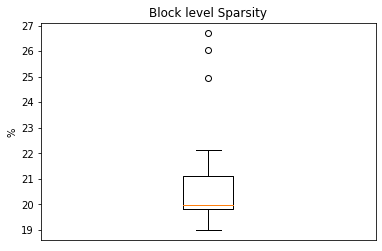

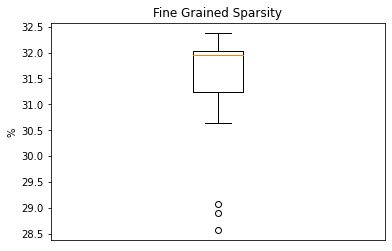

In [26]:
import matplotlib.pyplot as plt
# Plotting the coarse grain data
plt.boxplot(np.multiply(coarse_grain, 100))
plt.title("Block level Sparsity")  # Add a title for the plot
plt.xlabel("")      # Add a label for the x-axis
plt.ylabel("%")      # Add a label for the y-axis
plt.xticks([])
plt.savefig('../output/block_level2x2.png', dpi=300)                     # Show the first plot

# Plotting the fine grain data in a new figure
plt.figure()
plt.boxplot(np.multiply(fine_grain, 100))
plt.title("Fine Grained Sparsity")    # Add a title for the plot
plt.xlabel("")      # Add a label for the x-axis
plt.ylabel("%")      # Add a label for the y-axis
plt.xticks([])
plt.savefig('../output/fine_level2x2.png', dpi=300)                      # Show the second plot


In [23]:
def complement(i):
    fractions = 5
    i_quant = int(i*(2**fractions))
    if i_quant > (2**7 - 1):
        i_quant = (2**7 -1 )
    if i_quant < (-(2**7)):
        i_quant = -(2**7)
    if i_quant < 0:
        i_quant += (2**8)
    return i_quant


def get_hidden_flag(matrix, hidden_flags, block_size):
    N1 = matrix.shape[0]
    N2 = matrix.shape[1]
    for i in range(0, N1 - block_size + 1, block_size):
        for j in range(0, N2 - block_size + 1, block_size):
            a0 = complement(matrix[i,j]) << 24
            a1 = complement(matrix[i,j+1]) << 16
            a2 = complement(matrix[i,j+2]) << 8
            a3 = complement(matrix[i,j+3])
            flag = a0 + a1 + a2 + a3
            hidden_flags[flag] = True


In [24]:
hidden_flag_map = {}
for filename in files:
    if filename.endswith('.txt'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the data from the text file into a numpy array
        data = np.loadtxt(file_path)
        get_hidden_flag(data,hidden_flag_map, block_size=8)
        print(len(hidden_flag_map))

1023
2042
3057
4063
5080
6094
14249
15261
21106
22109
23105
24114
25117
33238
34223
35241
43354
44359
45368
46387
47348
48347
49362
50367
51383
52369
53383
54381
62432
67551
68556
73120
74076
75060
76016
80973
81982
86493
87483
88458
89431
90448
98417
102985
103997
112001
119905
120867
121828
125851
126827
127781
128745
129741
130698
131691
132701
136274
137240
145143
146069
147016
150847
151695
152653
153630
154583
155500
163379
164377
165313
168982
176794
177768
178736
179660
180649
184563
185525
192304
193289
194292
195210
196148
197085
203537
211325
212211
220009
221021
221945
222883
223860
227348
228273
229257
230236
231208
238508
239451
240416
241360
242255
243164
244075
244929
251208
254592
258255
259101
262502
265942
266820
270070
271029
271983
272895
273848
274762
281815
285353
286327
287253
288165
289074
292388
293268
294106
295068
296036
296860
297776
305417


In [32]:
total_blocks  = 0
for filename in files:
    if filename.endswith('.txt'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the data from the text file into a numpy array
        data = np.loadtxt(file_path)
        total_blocks += ((data.shape[0] / 8) * (data.shape[1] / 8))
total_blocks

397208.0

397208.0

In [38]:

def choose_hidden_flag(hidden_flag_map):
    sorted_flags = sorted(hidden_flag_map.keys())
    for i in range(12151, 2**32):
        if sorted_flags[i+1] != sorted_flags[i] +1:
            return sorted_flags[i] +1

In [39]:
choose_hidden_flag(hidden_flag_map)

1046274

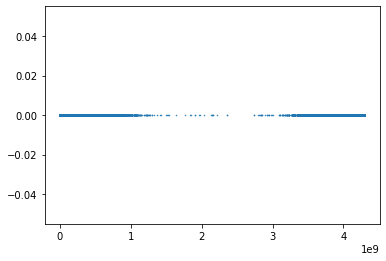

In [47]:
import matplotlib.pyplot as plt
X = np.array(list(hidden_flag_map.keys()))
plt.scatter( X, [0] * X.shape[0], marker = '.', s = 1)
plt.savefig('../output/hidden_flags_opportunity.png',dpi=300)